In [7]:
%matplotlib inline

In [65]:
# Import required libraries for data manipulation, machine learning, and visualization
import yfinance as yf  # Yahoo Finance API for downloading stock data
import pandas as pd  # Data manipulation and analysis library
import numpy as np  # Numerical computing library
from sklearn.preprocessing import MinMaxScaler  # For scaling data to 0-1 range
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Model evaluation metrics
from tensorflow.keras.models import Sequential  # Sequential neural network model
from tensorflow.keras.layers import LSTM, Dense, Dropout  # Neural network layers
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training
import matplotlib.pyplot as plt  # Plotting library (imported but not used in this script)
import ta  # Technical analysis library for financial indicators
from datetime import datetime, timedelta  # Date and time handling
import warnings  # Warning control
import plotly.graph_objects as go  # Interactive plotting library
from plotly.subplots import make_subplots  # For creating subplot layouts
import plotly.express as px  # Express plotting interface (imported but not used)
import tensorflow as tf  # TensorFlow machine learning framework
import os  # Operating system interface
import random  # Random number generation
from IPython.display import display, Markdown  # For displaying formatted output in Jupyter

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

In [67]:
# Set all random seeds for reproducibility
def set_seeds(seed=42):
    """Set all random seeds for reproducible results across all libraries"""
    random.seed(seed)  # Set Python's built-in random seed
    np.random.seed(seed)  # Set NumPy random seed
    tf.random.set_seed(seed)  # Set TensorFlow random seed
    os.environ['PYTHONHASHSEED'] = str(seed)  # Set hash seed for Python
    
    # Additional TensorFlow settings for reproducibility
    tf.keras.utils.set_random_seed(seed)  # Set Keras random seed
    tf.config.experimental.enable_op_determinism()  # Enable deterministic operations

# Set seeds at the beginning of script execution
set_seeds(42)


In [69]:
# Configuration dictionary mapping stock tickers to company names
COMPANY_NAMES = {
    'AAPL': 'Apple Inc.',  # Apple stock ticker
    'MSFT': 'Microsoft Corporation',  # Microsoft stock ticker
    'GOOGL': 'Alphabet Inc.',  # Google/Alphabet stock ticker
    'AMZN': 'Amazon.com Inc.',  # Amazon stock ticker
    'TSLA': 'Tesla Inc.',  # Tesla stock ticker
    'META': 'Meta Platforms Inc.',  # Meta/Facebook stock ticker
    'NVDA': 'NVIDIA Corporation',  # NVIDIA stock ticker
    'JPM': 'JPMorgan Chase & Co.',  # JPMorgan stock ticker
    'NFLX': 'Netflix Inc.',  # Netflix stock ticker
    'ADBE': 'Adobe Inc.'  # Adobe stock ticker
}

# Parameters - Can be modified as needed for different analysis scenarios
SELECTED_STOCKS = ['AAPL', 'MSFT', 'NVDA']  # Default selection of stocks to analyze
START_DATE = datetime(2022, 1, 1)  # Start date for historical data collection
END_DATE = datetime.now()  # End date (current date) for data collection
WINDOW_SIZE = 60  # Number of previous days to use for prediction (lookback period)
EPOCHS = 20  # Number of training iterations for the neural network


In [71]:
def add_watermark(fig):
    """Add watermark to plot for attribution"""
    fig.add_annotation(
        text="Priyanshu Joarder",  # Watermark text
        xref="paper", yref="paper",  # Reference to paper coordinates
        x=0.98, y=0.02,  # Position (bottom-right corner)
        xanchor='right', yanchor='bottom',  # Anchor points
        showarrow=False,  # Don't show arrow
        font=dict(size=10, color="rgba(128,128,128,0.5)"),  # Font styling
        bgcolor="rgba(255,255,255,0.3)",  # Background color
        bordercolor="rgba(128,128,128,0.3)",  # Border color
        borderwidth=1  # Border width
    )
    return fig  # Return the modified figure


In [73]:
def load_data(ticker, start_date, end_date):
    """Load and preprocess stock data with technical indicators"""
    try:
        print(f"Loading data for {ticker}...")  # Status message
        # Download stock data from Yahoo Finance
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        # Handle potential MultiIndex columns from yfinance
        if df.empty or isinstance(df.columns, pd.MultiIndex):
            # If columns are MultiIndex, remove the top level
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.droplevel(1)
        
        # Add technical indicators for analysis
        df['MA20'] = df['Close'].rolling(window=20).mean()  # 20-day moving average
        df['MA50'] = df['Close'].rolling(window=50).mean()  # 50-day moving average
        df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()  # Relative Strength Index
        
        # Calculate MACD (Moving Average Convergence Divergence)
        macd = ta.trend.MACD(close=df['Close'])
        df['MACD'] = macd.macd()  # MACD line
        df['MACD_signal'] = macd.macd_signal()  # MACD signal line
        
        # Calculate returns and volatility
        df['Returns'] = df['Close'].pct_change()  # Daily percentage returns
        df['Volatility'] = df['Returns'].rolling(window=20).std()  # 20-day volatility
        
        # Add volume moving average
        df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()  # 20-day volume moving average
        
        return df.dropna()  # Remove rows with NaN values
    except Exception as e:
        print(f"Error loading data for {ticker}: {str(e)}")  # Error handling
        return None  # Return None if loading fails


In [75]:
def build_and_train_model(df, window_size, epochs):
    """Build and train LSTM model with fixed seed for consistent results"""
    # Set seeds for reproducibility in model training
    np.random.seed(42)  # NumPy random seed
    tf.random.set_seed(42)  # TensorFlow random seed
    
    # Extract closing prices for model training
    data = df[['Close']].values  # Convert to numpy array
    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize scaler for 0-1 normalization
    scaled_data = scaler.fit_transform(data)  # Scale the data
    
    def create_sequences(data, window):
        """Create sequences for LSTM training (X: input sequences, y: targets)"""
        X, y = [], []  # Initialize input and target lists
        # Create sliding window sequences
        for i in range(window, len(data)):
            X.append(data[i-window:i, 0])  # Previous 'window' days as input
            y.append(data[i, 0])  # Current day as target
        return np.array(X), np.array(y)  # Convert to numpy arrays
    
    # Create sequences for training
    X, y = create_sequences(scaled_data, window_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input (samples, timesteps, features)
    
    # Split data into training and testing sets (80-20 split)
    split = int(len(X) * 0.8)  # Calculate split index
    X_train, X_test = X[:split], X[split:]  # Split input data
    y_train, y_test = y[:split], y[split:]  # Split target data
    
    # Build LSTM model architecture
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(window_size, 1)),  # First LSTM layer with 50 units
        Dropout(0.2),  # Dropout layer to prevent overfitting (20% dropout)
        LSTM(50, return_sequences=False),  # Second LSTM layer with 50 units
        Dropout(0.2),  # Another dropout layer
        Dense(25),  # Dense layer with 25 neurons
        Dense(1)  # Output layer with 1 neuron (price prediction)
    ])
    
    # Compile model with fixed learning rate for consistency
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    print('Training model...')  # Status message
    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=0, shuffle=False)
    
    # Make predictions on test set
    predictions = model.predict(X_test)  # Get scaled predictions
    predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Convert actual values back
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))  # Root Mean Square Error
    mae = mean_absolute_error(y_test_actual, predictions)  # Mean Absolute Error
    mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100  # Mean Absolute Percentage Error
    
    # Predict next day's price
    last_sequence = scaled_data[-window_size:]  # Get last 'window_size' days
    last_sequence = np.reshape(last_sequence, (1, window_size, 1))  # Reshape for prediction
    next_price_scaled = model.predict(last_sequence)  # Get scaled prediction
    next_price = scaler.inverse_transform(next_price_scaled)[0, 0]  # Convert to original scale
    
    # Return all results
    return y_test_actual.flatten(), predictions.flatten(), next_price, rmse, mae, mape


In [77]:
def calculate_stock_score(df, next_price, current_price, mape):
    """Calculate stock score based on multiple factors"""
    # Calculate expected return percentage
    expected_return = ((next_price - current_price) / current_price) * 100
    rsi = df['RSI'].iloc[-1]  # Get latest RSI value
    
    # Calculate component scores
    prediction_score = min(max(expected_return * 10, -50), 50)  # Score based on expected return (capped at ±50)
    rsi_score = 100 - abs(rsi - 50) * 2  # Score based on RSI (higher when RSI is near 50)
    accuracy_score = max(100 - mape, 0)  # Score based on model accuracy
    
    # Calculate weighted total score
    total_score = (prediction_score * 0.5 + rsi_score * 0.3 + accuracy_score * 0.2)
    
    # Return dictionary with all score components
    return {
        'total_score': total_score,  # Overall score
        'expected_return': expected_return,  # Expected return percentage
        'current_price': current_price,  # Current stock price
        'predicted_price': next_price,  # Predicted next price
        'rsi': rsi,  # RSI value
        'accuracy': accuracy_score  # Model accuracy score
    }


In [79]:
def create_individual_charts(df, ticker, actual, predicted):
    """Create individual stock analysis charts with equal-sized volume graph"""
    company_name = COMPANY_NAMES.get(ticker, ticker)  # Get company name
    
    # Combined Price and Volume Chart - WITH VOLUME MOVING AVERAGE
    fig1 = make_subplots(
        rows=2, cols=1,  # 2 rows, 1 column layout
        shared_xaxes=True,  # Share x-axis between subplots
        subplot_titles=[f'{company_name} Stock Price', f'{company_name} - Volume Analysis'],  # Subplot titles
        vertical_spacing=0.15,  # Space between subplots
        row_heights=[0.5, 0.5]  # Equal height for both subplots
    )
    
    # Add price data traces
    fig1.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close', line=dict(color='blue', width=2)), row=1, col=1)
    fig1.add_trace(go.Scatter(x=df.index, y=df['MA20'], name='MA20', line=dict(color='orange', width=1)), row=1, col=1)
    fig1.add_trace(go.Scatter(x=df.index, y=df['MA50'], name='MA50', line=dict(color='green', width=1)), row=1, col=1)
    
    # Create color coding for volume bars based on daily returns
    colors = ['green' if df['Returns'].iloc[i] > 0 else 'red' for i in range(len(df))]
    # Add volume bar chart
    fig1.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume', marker_color=colors, opacity=0.6), row=2, col=1)
    
    # Add volume moving average line
    fig1.add_trace(go.Scatter(
        x=df.index, 
        y=df['Volume_MA20'], 
        name='Volume MA20', 
        line=dict(color='blue', width=2),
        mode='lines'
    ), row=2, col=1)
    
    # Update layout for price and volume chart
    fig1.update_layout(title=f'{company_name} - Price & Volume Analysis', height=800)
    fig1.update_yaxes(title_text="Price ($)", row=1, col=1)  # Y-axis label for price
    fig1.update_xaxes(title_text="Date", row=1, col=1)  # X-axis label for price
    fig1.update_yaxes(title_text="Volume", row=2, col=1)  # Y-axis label for volume
    fig1.update_xaxes(title_text="Date", row=2, col=1)  # X-axis label for volume
    fig1 = add_watermark(fig1)  # Add watermark
    fig1.show()  # Display the chart
    
    # Combined RSI and MACD in Single Chart
    fig2 = go.Figure()  # Create new figure
    
    # Add RSI on primary y-axis
    fig2.add_trace(go.Scatter(x=df.index, y=df['RSI'], name='RSI', 
                             line=dict(color='purple', width=2), yaxis='y'))
    
    # Add MACD on secondary y-axis
    fig2.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD', 
                             line=dict(color='blue', width=2), yaxis='y2'))
    fig2.add_trace(go.Scatter(x=df.index, y=df['MACD_signal'], name='MACD Signal', 
                             line=dict(color='red', width=1), yaxis='y2'))
    
    # Add MACD histogram on secondary y-axis
    macd_histogram = df['MACD'] - df['MACD_signal']  # Calculate MACD histogram
    colors = ['green' if val > 0 else 'red' for val in macd_histogram]  # Color coding
    fig2.add_trace(go.Bar(x=df.index, y=macd_histogram, name='MACD Histogram', 
                         marker_color=colors, opacity=0.3, yaxis='y2'))
    
    # Add RSI reference lines
    fig2.add_hline(y=70, line_dash="dash", line_color="red", annotation_text="RSI Overbought (70)")
    fig2.add_hline(y=30, line_dash="dash", line_color="green", annotation_text="RSI Oversold (30)")
    fig2.add_hline(y=50, line_dash="dot", line_color="gray", annotation_text="RSI Neutral (50)")
    
    # Configure layout with dual y-axes
    fig2.update_layout(
        title=f'{company_name} - RSI & MACD Combined',
        xaxis_title='Date',
        yaxis=dict(title='RSI', side='left', range=[0, 100], color='purple'),  # Left y-axis for RSI
        yaxis2=dict(title='MACD', side='right', overlaying='y', color='blue'),  # Right y-axis for MACD
        height=400,
        legend=dict(x=0.01, y=0.99)  # Legend position
    )
    fig2 = add_watermark(fig2)  # Add watermark
    fig2.show()  # Display the chart
    
    # Prediction Chart
    fig3 = go.Figure()  # Create new figure
    # Add actual vs predicted price traces
    fig3.add_trace(go.Scatter(y=actual, name='Actual', line=dict(color='blue', width=2)))
    fig3.add_trace(go.Scatter(y=predicted, name='Predicted', line=dict(color='red', width=2, dash='dash')))
    fig3.update_layout(title=f'{company_name} - Prediction vs Actual', xaxis_title='Time', yaxis_title='Price ($)', height=400)
    fig3 = add_watermark(fig3)  # Add watermark
    fig3.show()  # Display the chart


In [81]:
def create_comparison_charts(results, stock_scores):
    """Create comparison charts for all stocks"""
    
    # Price Comparison Chart
    fig1 = go.Figure()  # Create new figure
    # Add normalized price traces for each stock
    for ticker, result in results.items():
        company_name = COMPANY_NAMES.get(ticker, ticker)  # Get company name
        df = result['df']  # Get dataframe
        # Normalize prices to show percentage change from start
        normalized_price = (df['Close'] / df['Close'].iloc[0] - 1) * 100
        fig1.add_trace(go.Scatter(x=df.index, y=normalized_price, name=f'{company_name} ({ticker})', 
                                 line=dict(width=2)))
    
    # Update layout for price comparison
    fig1.update_layout(title='Stock Performance Comparison (% Change)', 
                      xaxis_title='Date', yaxis_title='Price Change (%)', height=500)
    fig1 = add_watermark(fig1)  # Add watermark
    fig1.show()  # Display the chart
    
    # RSI Comparison Chart
    fig2 = go.Figure()  # Create new figure
    # Add RSI traces for each stock
    for ticker, result in results.items():
        company_name = COMPANY_NAMES.get(ticker, ticker)  # Get company name
        df = result['df']  # Get dataframe
        fig2.add_trace(go.Scatter(x=df.index, y=df['RSI'], name=f'{company_name} ({ticker})', 
                                 line=dict(width=2)))
    
    # Add RSI reference lines
    fig2.add_hline(y=70, line_dash="dash", line_color="red", annotation_text="Overbought")
    fig2.add_hline(y=30, line_dash="dash", line_color="green", annotation_text="Oversold")
    fig2.update_layout(title='RSI Comparison', xaxis_title='Date', yaxis_title='RSI', height=400)
    fig2 = add_watermark(fig2)  # Add watermark
    fig2.show()  # Display the chart
    
    # Score Comparison Bar Chart
    tickers = list(stock_scores.keys())  # Get list of tickers
    scores = [stock_scores[ticker]['total_score'] for ticker in tickers]  # Get scores
    expected_returns = [stock_scores[ticker]['expected_return'] for ticker in tickers]  # Get expected returns
    company_names = [COMPANY_NAMES.get(ticker, ticker) for ticker in tickers]  # Get company names
    
    # Create subplots for scores and returns
    fig3 = make_subplots(rows=1, cols=2, subplot_titles=['Overall Scores', 'Expected Returns (%)'])
    
    # Add score bars
    fig3.add_trace(go.Bar(x=company_names, y=scores, name='Score', marker_color='lightblue'), row=1, col=1)
    # Add return bars with color coding
    fig3.add_trace(go.Bar(x=company_names, y=expected_returns, name='Return %', 
                         marker_color=['green' if x > 0 else 'red' for x in expected_returns]), row=1, col=2)
    
    fig3.update_layout(title='Stock Comparison - Scores & Expected Returns', height=400, showlegend=False)
    fig3 = add_watermark(fig3)  # Add watermark
    fig3.show()  # Display the chart


In [83]:
def save_results_to_csv(results, stock_scores):
    """Save results to CSV files"""
    # Summary CSV
    summary_data = []  # Initialize summary data list
    # Process each stock's results
    for ticker, score_data in stock_scores.items():
        company_name = COMPANY_NAMES.get(ticker, ticker)  # Get company name
        result_data = results[ticker]  # Get result data
        
        # Create summary record
        summary_data.append({
            'Ticker': ticker,  # Stock ticker
            'Company': company_name,  # Company name
            'Overall_Score': score_data['total_score'],  # Overall score
            'Expected_Return_Percent': score_data['expected_return'],  # Expected return
            'Current_Price_USD': score_data['current_price'],  # Current price
            'Predicted_Price_USD': score_data['predicted_price'],  # Predicted price
            'RSI': score_data['rsi'],  # RSI value
            'Model_Accuracy_Score': score_data['accuracy'],  # Model accuracy
            'RMSE': result_data['rmse'],  # Root Mean Square Error
            'MAE': result_data['mae'],  # Mean Absolute Error
            'MAPE_Percent': result_data['mape'],  # Mean Absolute Percentage Error
            'Analysis_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')  # Analysis timestamp
        })
    
    # Create summary dataframe and sort by score
    summary_df = pd.DataFrame(summary_data).sort_values('Overall_Score', ascending=False)
    summary_df.to_csv('stock_analysis_summary.csv', index=False)  # Save to CSV
    
    # Combined stock data CSV
    all_stock_data = []  # Initialize combined data list
    # Process each stock's dataframe
    for ticker, result in results.items():
        df = result['df'].copy()  # Copy dataframe
        df['Ticker'] = ticker  # Add ticker column
        df['Company'] = COMPANY_NAMES.get(ticker, ticker)  # Add company column
        all_stock_data.append(df)  # Add to list
    
    # Combine all dataframes if data exists
    if all_stock_data:
        combined_df = pd.concat(all_stock_data, ignore_index=False)  # Concatenate dataframes
        combined_df.to_csv('stock_data.csv')  # Save to CSV
    
    print("✅ Files saved: stock_analysis_summary.csv & stock_data.csv")  # Confirmation message
    return summary_df  # Return summary dataframe


In [85]:
def print_dataframe(df):
    """Print dataframe in a nice format for terminal"""
    print(df.to_string(index=False))  # Print without row indices


In [87]:
def run_stock_analysis(selected_stocks=None, start_date=None, end_date=None, 
                      window_size=None, epochs=None):
    """Main analysis function with configurable parameters"""
    # Use default values if not provided
    if selected_stocks is None:
        selected_stocks = SELECTED_STOCKS  # Use default stock selection
    if start_date is None:
        start_date = START_DATE  # Use default start date
    if end_date is None:
        end_date = END_DATE  # Use default end date
    if window_size is None:
        window_size = WINDOW_SIZE  # Use default window size
    if epochs is None:
        epochs = EPOCHS  # Use default epochs
    
    # Print analysis header
    print("📈 Starting Stock Prediction Analysis")
    print("=" * 50)
    print(f"Analyzing stocks: {', '.join(selected_stocks)}")
    print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Window size: {window_size}, Epochs: {epochs}")
    print("=" * 50)
    
    # Initialize result storage
    results = {}  # Store analysis results
    stock_scores = {}  # Store calculated scores
    
    # Process all stocks
    for i, ticker in enumerate(selected_stocks):
        company_name = COMPANY_NAMES.get(ticker, ticker)  # Get company name
        print(f"\n[{i+1}/{len(selected_stocks)}] Processing {company_name} ({ticker})...")
        
        # Load stock data
        df = load_data(ticker, start_date, end_date)
        if df is None:  # Skip if data loading failed
            continue
        
        try:
            # Build and train model, get predictions
            actual, predicted, next_price, rmse, mae, mape = build_and_train_model(df, window_size, epochs)
            current_price = df['Close'].iloc[-1]  # Get latest closing price
            
            # Store results
            results[ticker] = {
                'actual': actual,  # Actual test prices
                'predicted': predicted,  # Predicted test prices
                'next_price': next_price,  # Next day prediction
                'current_price': current_price,  # Current price
                'rmse': rmse,  # Root Mean Square Error
                'mae': mae,  # Mean Absolute Error
                'mape': mape,  # Mean Absolute Percentage Error
                'df': df  # Complete dataframe
            }
            
            # Calculate stock score
            stock_scores[ticker] = calculate_stock_score(df, next_price, current_price, mape)
            
            # Print individual stock results
            print(f"✅ {company_name} analysis completed")
            print(f"   Current Price: ${current_price:.2f}")
            print(f"   Predicted Price: ${next_price:.2f}")
            print(f"   Expected Return: {stock_scores[ticker]['expected_return']:.2f}%")
            print(f"   Model MAPE: {mape:.1f}%")
            
        except Exception as e:
            print(f"❌ Error analyzing {company_name}: {str(e)}")  # Error handling
    
    # Check if any stocks were analyzed successfully
    if not results:
        print("❌ No stocks analyzed successfully")
        return None, None
    
    # Save results and show summary
    summary_df = save_results_to_csv(results, stock_scores)
    
    print("\n" + "=" * 50)
    print("📊 ANALYSIS RESULTS")
    print("=" * 50)
    
    # Show best recommendation
    sorted_stocks = sorted(stock_scores.items(), key=lambda x: x[1]['total_score'], reverse=True)
    if sorted_stocks:
        best_stock = sorted_stocks[0]  # Get highest scoring stock
        best_ticker = best_stock[0]  # Get ticker
        best_company = COMPANY_NAMES.get(best_ticker, best_ticker)  # Get company name
        
        # Print best recommendation details
        print(f"\n🏆 TOP RECOMMENDATION: {best_company} ({best_ticker})")
        print("-" * 50)
        print(f"Overall Score: {best_stock[1]['total_score']:.1f}/100")
        print(f"Expected Return: {best_stock[1]['expected_return']:.2f}%")
        print(f"Current Price: ${best_stock[1]['current_price']:.2f}")
        print(f"Target Price: ${best_stock[1]['predicted_price']:.2f}")
        print(f"RSI: {best_stock[1]['rsi']:.1f}")
        print(f"Model MAPE: {results[best_ticker]['mape']:.1f}%")
    
    # Display comparison table
    print(f"\n📋 STOCK COMPARISON")
    print("-" * 50)
    print_dataframe(summary_df)  # Print formatted dataframe
    
    # Show comparison charts
    print(f"\n📊 Creating Comparison Charts...")
    create_comparison_charts(results, stock_scores)
    
    # Show individual charts
    print(f"\n📈 Individual Stock Analysis Charts...")
    print("-" * 50)
    for ticker in results:
        company_name = COMPANY_NAMES.get(ticker, ticker)  # Get company name
        print(f"\nGenerating charts for {company_name}...")
        # Create individual charts for each stock
        create_individual_charts(results[ticker]['df'], ticker, 
                               results[ticker]['actual'], results[ticker]['predicted'])
    
    # Print completion message
    print("\n" + "=" * 50)
    print("✅ ANALYSIS COMPLETE!")
    print("=" * 50)
    print("📁 Files created:")
    print("  • stock_data.csv - Complete stock data with technical indicators")
    print("  • stock_analysis_summary.csv - Summary results and scores")
    print("\n⚠️  Disclaimer: AI-generated recommendations. Always do your own research!")
    
    return results, stock_scores  # Return analysis results


In [89]:
def interactive_stock_selection():
    """Interactive function to select stocks and parameters"""
    print("📈 Stock Prediction Analysis Tool")
    print("=" * 50)
    
    # Show available stocks
    print("Available stocks:")
    for i, (ticker, name) in enumerate(COMPANY_NAMES.items(), 1):
        print(f"{i:2d}. {ticker} - {name}")  # Print numbered list
    
    # Get user selection
    print("\nSelect stocks to analyze:")
    print("1. Use default selection (AAPL, MSFT, NVDA)")
    print("2. Select custom stocks")
    
    choice = input("Enter your choice (1 or 2): ").strip()  # Get user input
    
    if choice == "2":  # Custom selection
        print("\nEnter stock tickers separated by commas (e.g., AAPL,MSFT,TSLA):")
        tickers_input = input("Tickers: ").strip().upper()  # Get ticker input
        selected_stocks = [t.strip() for t in tickers_input.split(",") if t.strip()]  # Parse comma-separated tickers
        
        # Validate tickers against available options
        valid_stocks = [t for t in selected_stocks if t in COMPANY_NAMES]
        if not valid_stocks:  # If no valid tickers found
            print("No valid tickers found. Using default selection.")
            selected_stocks = SELECTED_STOCKS  # Fall back to default
        else:
            selected_stocks = valid_stocks  # Use valid tickers
            print(f"Selected stocks: {', '.join(selected_stocks)}")  # Confirmation message
    else:
        selected_stocks = SELECTED_STOCKS  # Use default selection
        print(f"Using default selection: {', '.join(selected_stocks)}")  # Confirmation message
    
    # Optional: Ask for custom parameters
    print("\nUse default parameters? (Y/n)")
    use_defaults = input().strip().lower() or 'y'  # Get user preference (default to 'y')
    
    if use_defaults == 'n':  # If user wants custom parameters
        try:
            # Get custom epochs value
            epochs = int(input(f"Enter number of epochs (default {EPOCHS}): ") or EPOCHS)
            # Get custom window size value
            window_size = int(input(f"Enter window size (default {WINDOW_SIZE}): ") or WINDOW_SIZE)
        except ValueError:  # Handle invalid input
            print("Invalid input. Using default parameters.")
            epochs = EPOCHS  # Use default epochs
            window_size = WINDOW_SIZE  # Use default window size
    else:
        epochs = EPOCHS  # Use default epochs
        window_size = WINDOW_SIZE  # Use default window size
    
    # Return all selected parameters
    return selected_stocks, START_DATE, END_DATE, window_size, epochs


<h1 style='text-align: center; color: mediumblue;'>Stock Prediction Analysis by Priyanshu Joarder</h1>


Choose execution mode:
1. Run with default settings
2. Interactive mode
3. Quick analysis (fewer epochs)


Enter your choice (1, 2, or 3):  2


📈 Stock Prediction Analysis Tool
Available stocks:
 1. AAPL - Apple Inc.
 2. MSFT - Microsoft Corporation
 3. GOOGL - Alphabet Inc.
 4. AMZN - Amazon.com Inc.
 5. TSLA - Tesla Inc.
 6. META - Meta Platforms Inc.
 7. NVDA - NVIDIA Corporation
 8. JPM - JPMorgan Chase & Co.
 9. NFLX - Netflix Inc.
10. ADBE - Adobe Inc.

Select stocks to analyze:
1. Use default selection (AAPL, MSFT, NVDA)
2. Select custom stocks


Enter your choice (1 or 2):  2



Enter stock tickers separated by commas (e.g., AAPL,MSFT,TSLA):


Tickers:  JPM,NFLX,ADBE


Selected stocks: JPM, NFLX, ADBE

Use default parameters? (Y/n)


 y


📈 Starting Stock Prediction Analysis
Analyzing stocks: JPM, NFLX, ADBE
Date range: 2022-01-01 to 2025-06-27
Window size: 60, Epochs: 20

[1/3] Processing JPMorgan Chase & Co. (JPM)...
Loading data for JPM...
Training model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ JPMorgan Chase & Co. analysis completed
   Current Price: $287.38
   Predicted Price: $290.94
   Expected Return: 1.24%
   Model MAPE: 3.5%

[2/3] Processing Netflix Inc. (NFLX)...
Loading data for NFLX...
Training model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
✅ Netflix Inc. analysis completed
   Current Price: $1319.46
   Predicted Price: $1421.76
   Expected Return: 7.75%
   Model MAPE: 6.7%

[3/3] Processing Adobe Inc. (ADBE)...
Loading data for ADBE...
Training model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ Adobe Inc. analysis completed
   Current Price: $388.32
   Predicted Price: $392.51
   Expected Retu

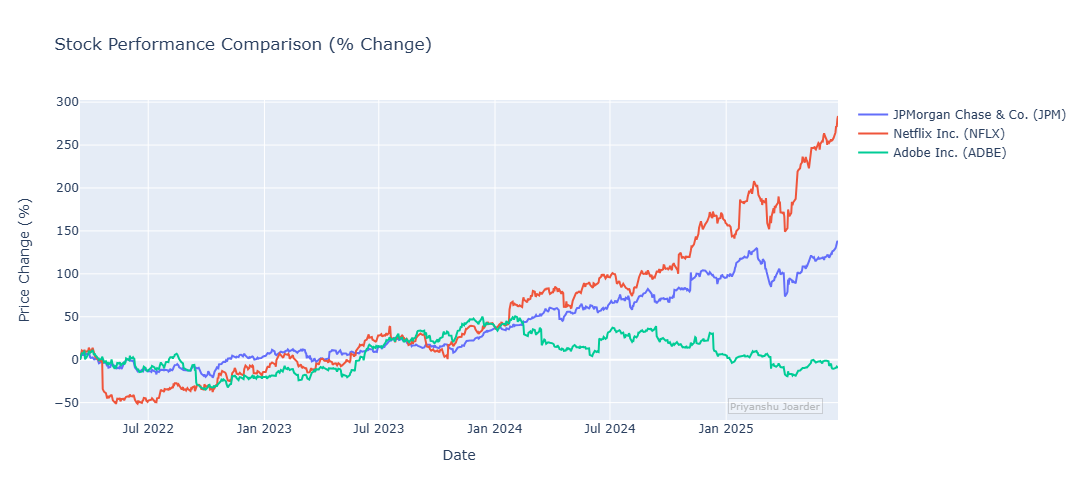

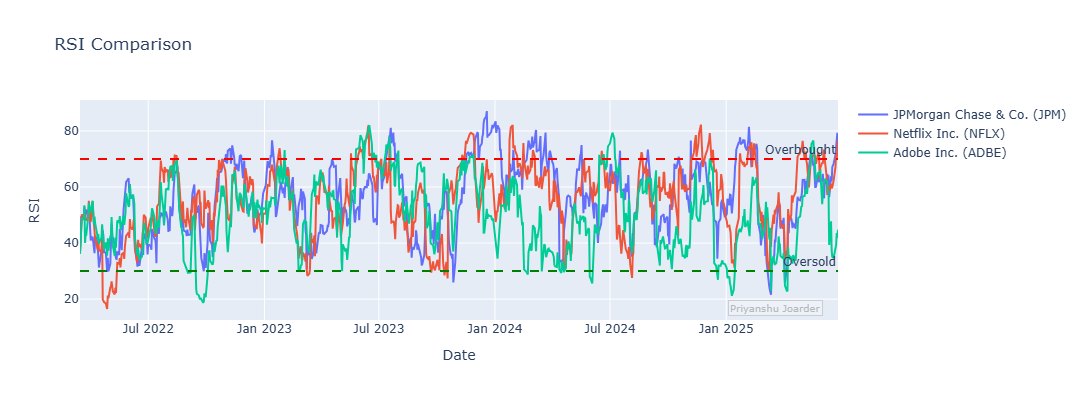

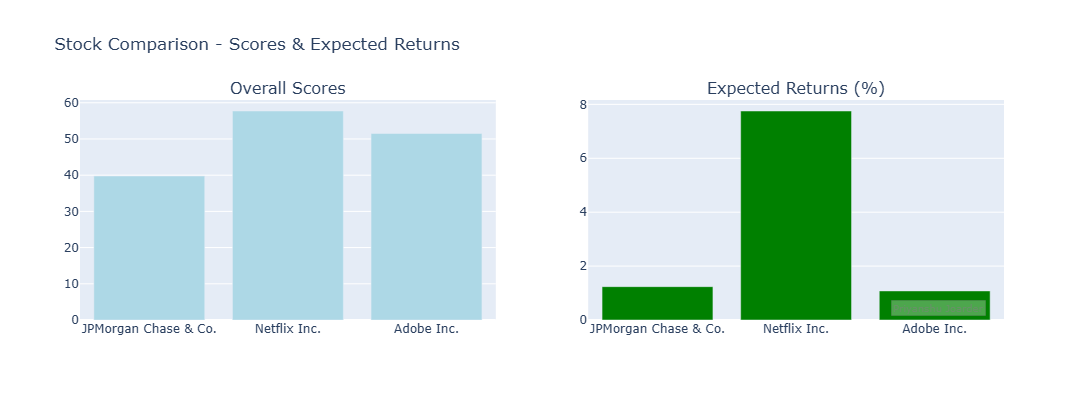


📈 Individual Stock Analysis Charts...
--------------------------------------------------

Generating charts for JPMorgan Chase & Co....


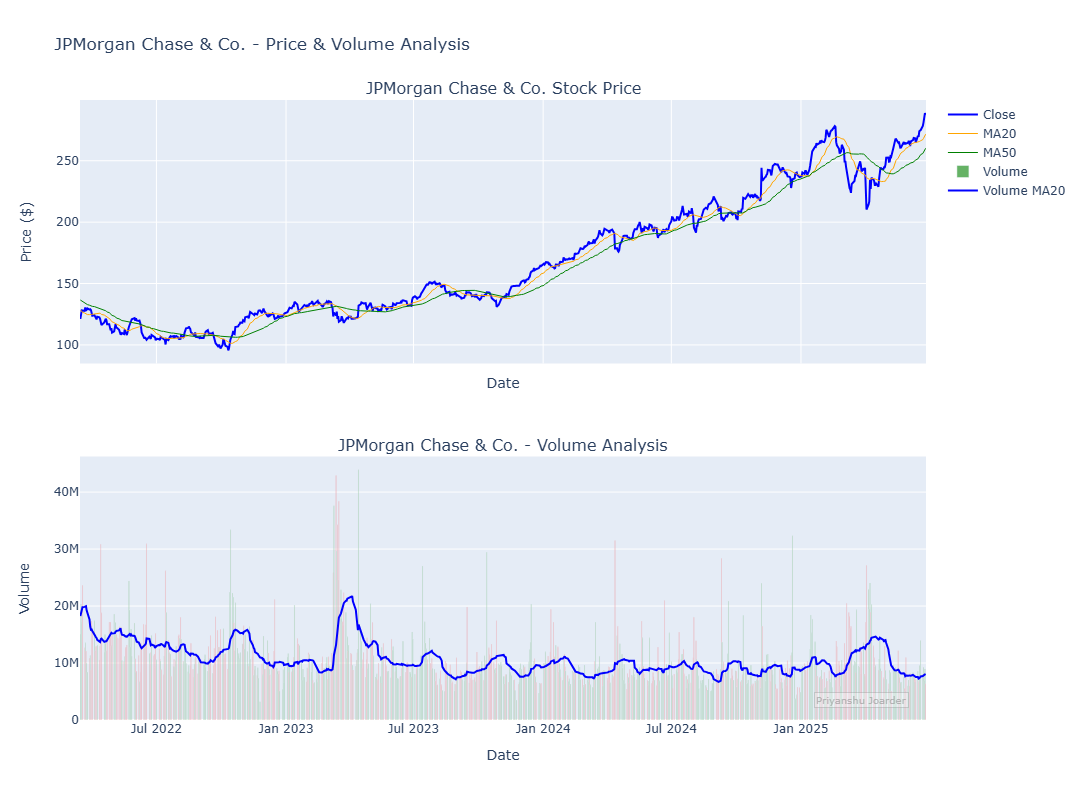

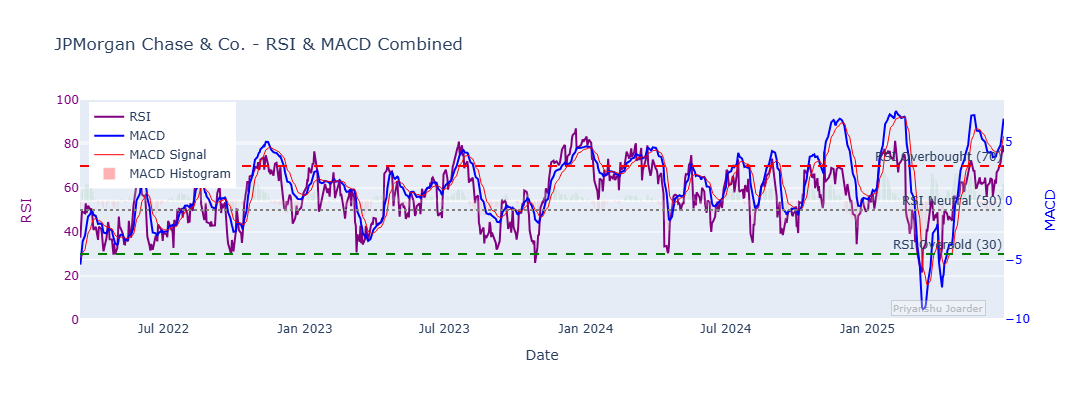

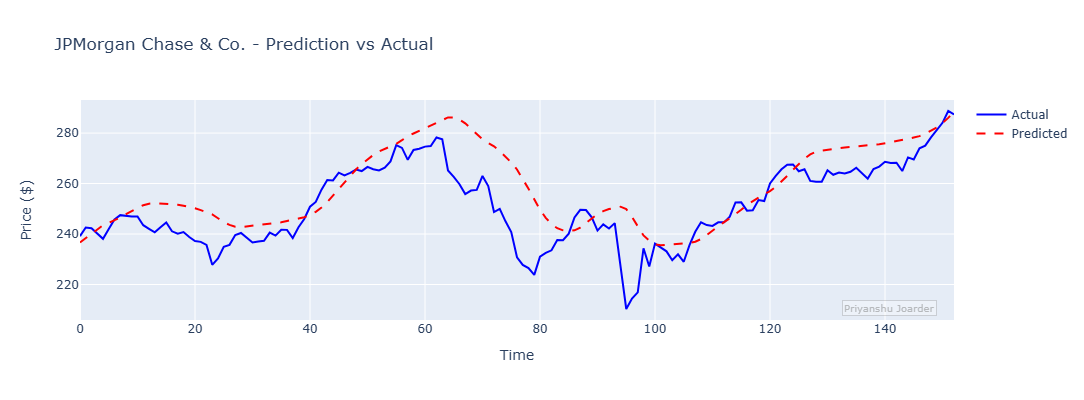


Generating charts for Netflix Inc....


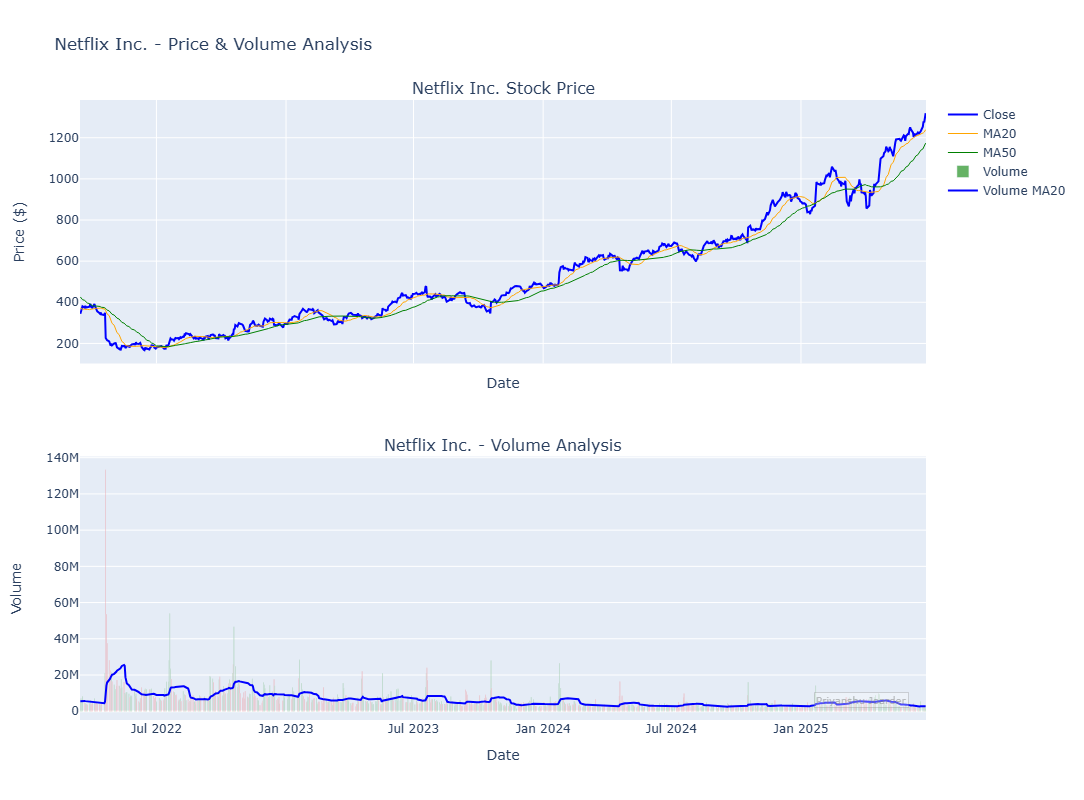

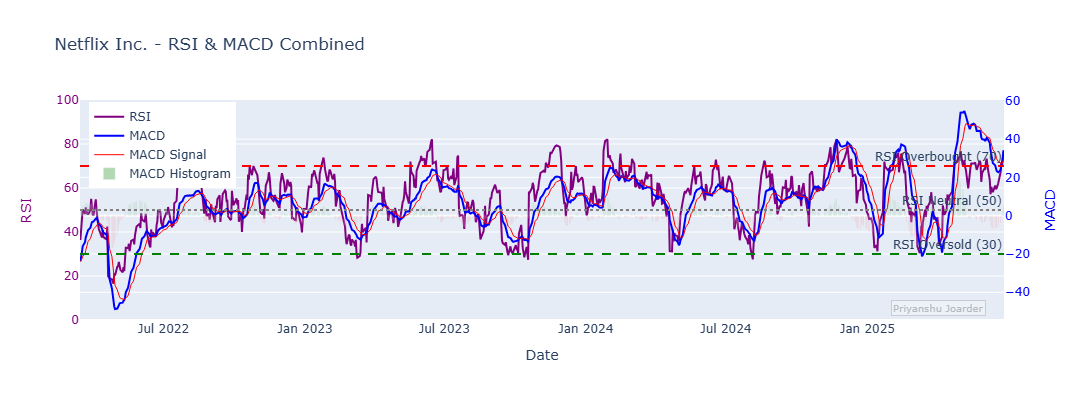

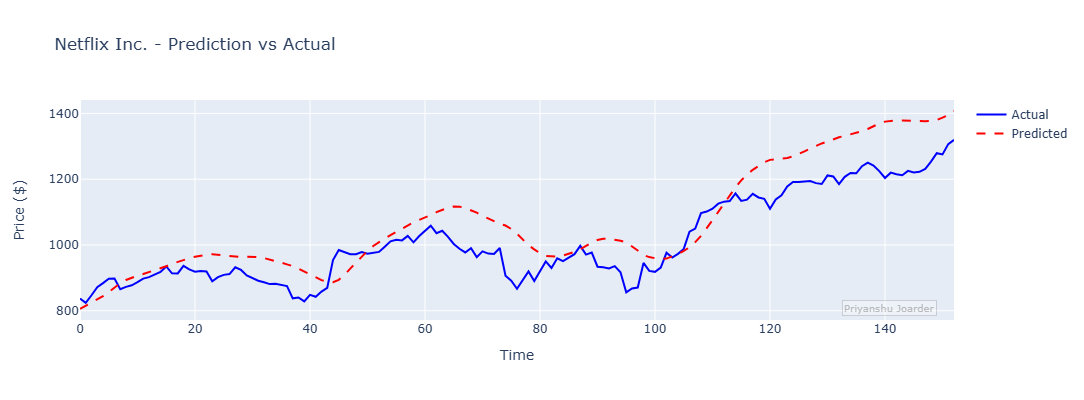


Generating charts for Adobe Inc....


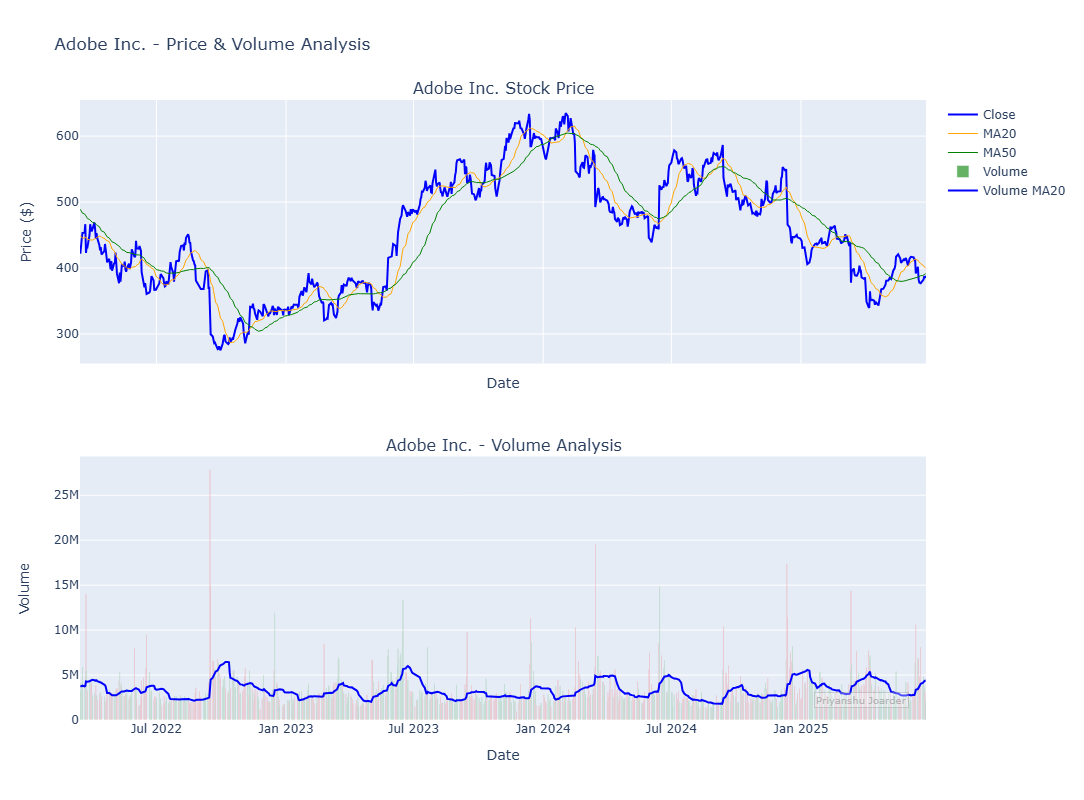

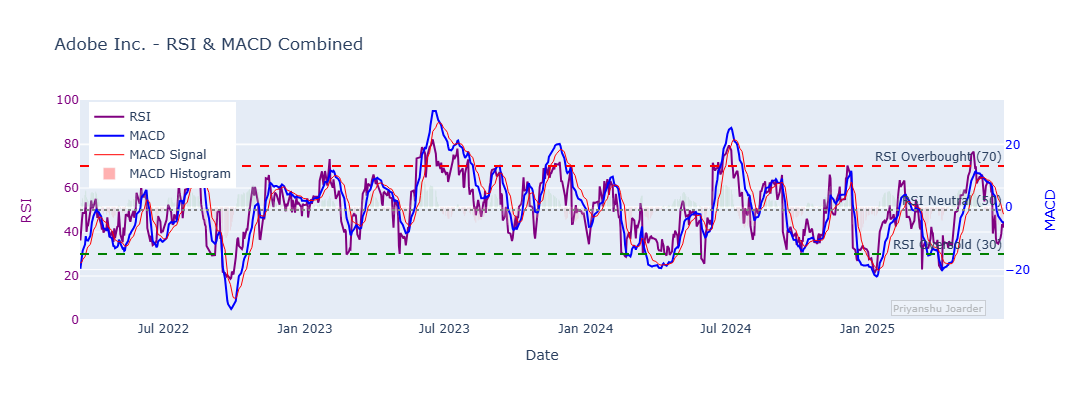

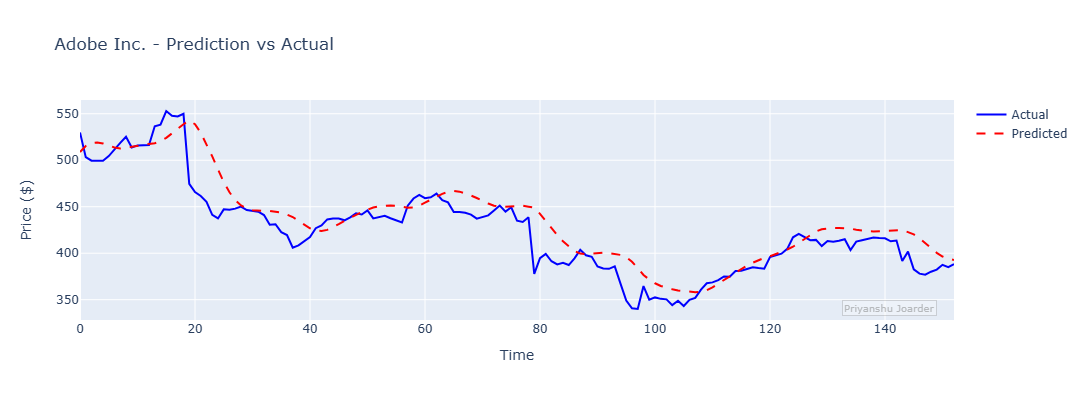


✅ ANALYSIS COMPLETE!
📁 Files created:
  • stock_data.csv - Complete stock data with technical indicators
  • stock_analysis_summary.csv - Summary results and scores

⚠️  Disclaimer: AI-generated recommendations. Always do your own research!

🎉 Analysis completed successfully!
📊 3 stocks analyzed
📁 Check the generated CSV files for detailed results


In [97]:
# Main execution block - runs when script is executed directly
if __name__ == "__main__":
    # Display title with Markdown formatting for Jupyter notebooks
    display(Markdown("<h1 style='text-align: center; color: mediumblue;'>Stock Prediction Analysis by Priyanshu Joarder</h1>"))
    print()  # Empty line for spacing
    
    # Present execution mode options to user
    print("Choose execution mode:")
    print("1. Run with default settings")  # Default mode with pre-configured settings
    print("2. Interactive mode")  # Interactive mode for custom selection
    print("3. Quick analysis (fewer epochs)")  # Quick mode with reduced training time
    
    # Get user's mode selection (default to "1" if no input)
    mode = input("Enter your choice (1, 2, or 3): ").strip() or "1"
    
    if mode == "2":  # Interactive mode
        # Get custom parameters from user
        selected_stocks, start_date, end_date, window_size, epochs = interactive_stock_selection()
        # Run analysis with custom parameters
        results, stock_scores = run_stock_analysis(selected_stocks, start_date, end_date, window_size, epochs)
    elif mode == "3":  # Quick analysis mode
        print("Running quick analysis with reduced epochs...")
        # Run analysis with fewer epochs for faster execution
        results, stock_scores = run_stock_analysis(epochs=5)
    else:  # Default mode (mode == "1" or any other input)
        print("Running with default settings...")
        # Run analysis with all default parameters
        results, stock_scores = run_stock_analysis()
    
    # Check if analysis completed successfully
    if results:
        print(f"\n🎉 Analysis completed successfully!")  # Success message
        print(f"📊 {len(results)} stocks analyzed")  # Number of stocks processed
        print("📁 Check the generated CSV files for detailed results")  # File output reminder
    else:
        print("❌ Analysis failed. Please check your internet connection and try again.")  # Failure message
